In [274]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, RandomOverSampler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [357]:
df = pd.read_csv('train_HR.csv')

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [4]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
df['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

### We can see that dataset is imbalanced. Only 8.5% data contains promoted class as true.
### Checking for null values.

In [6]:
null_series = df.isnull().sum()
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

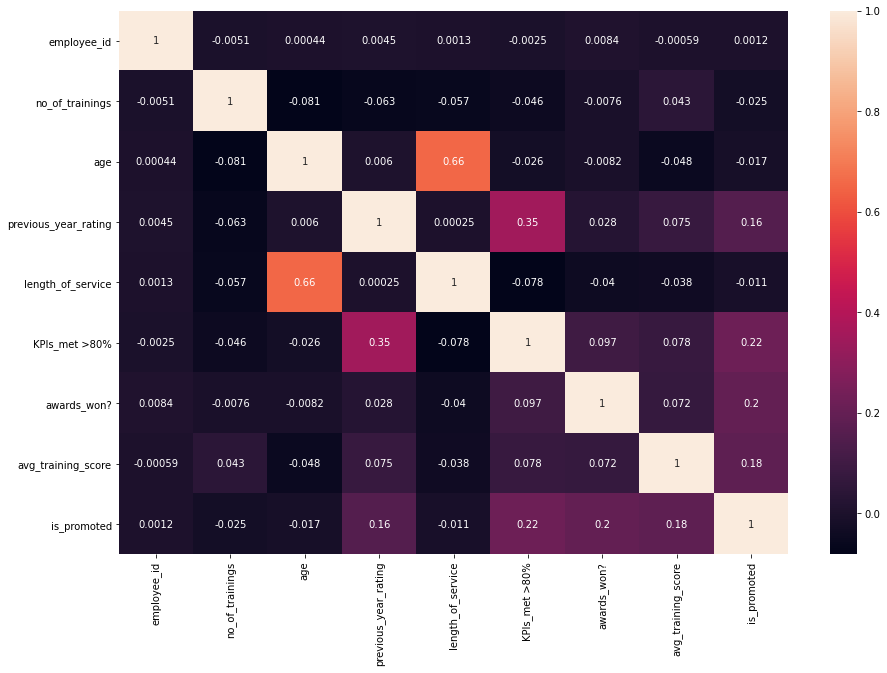

In [7]:
fig = plt.gcf()
fig.set_size_inches(15,10)
sns.heatmap(df.corr(), annot=True)
plt.show()

In [8]:
cat_features = []
num_features = []
for col in df.columns:
    if (df[col].dtype =='O'):
        cat_features.append(col)
    else:
        if (df[col].unique().size > 10):
            num_features.append(col)
        else:
            cat_features.append(col)

In [9]:
cat_features

['department',
 'region',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'previous_year_rating',
 'KPIs_met >80%',
 'awards_won?',
 'is_promoted']

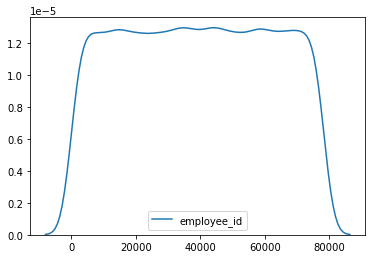

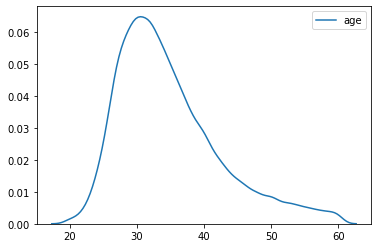

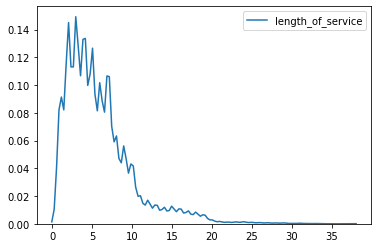

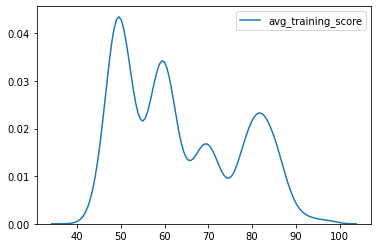

In [10]:
for col in num_features:
    sns.kdeplot(df[col])
    plt.show()

In [11]:
skew_data = df[num_features].skew(axis = 0, skipna = True)
skewed_feat = []
skewed_feat = skew_data[skew_data > 1.1].index.values
skewed_feat

array(['length_of_service'], dtype=object)

#### We can see length of service has large skewness. So we can try log transformation on it

In [12]:
# checking if lenght of service has any values less than 1.
df[df['length_of_service'] < 1]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted


In [13]:
df['log_length_of_service'] = np.log(df['length_of_service'])

In [14]:

df['log_length_of_service'].skew(axis = 0, skipna = True)

-0.28990179567467633

In [359]:
df_new = df.copy()

In [53]:
df_region_depart_mean_train_score = df_new.groupby(['region', 'department'])['avg_training_score'].agg('mean').unstack()

In [54]:
df_region_depart_mean_train_score

department,Analytics,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,Technology
region,,,,,,,,,
region_1,84.855263,59.285714,55.428571,63.000000,60.000000,69.833333,NaN,51.079019,79.671233
region_10,85.076923,59.615385,50.533333,NaN,59.528736,70.203947,87.500000,50.051064,80.084746
region_11,84.546875,60.140351,49.414634,59.181818,59.950178,69.965517,83.553191,49.777778,79.543046
region_12,84.756757,59.500000,50.444444,61.750000,60.209150,70.548387,83.500000,50.949438,79.729730
region_13,84.601504,60.586207,49.457831,59.343750,60.192593,70.152941,85.307692,50.462622,79.937343
region_14,84.770833,59.652174,50.500000,NaN,59.625000,70.305085,86.500000,50.492212,79.710280
region_15,84.611111,59.394737,50.134328,61.000000,60.275648,70.327778,85.032258,49.865155,80.639269
region_16,84.186441,60.148148,49.243243,60.090909,60.462585,69.428571,84.300000,50.132867,80.087302
region_17,83.846154,61.000000,48.736842,60.333333,60.836957,70.361032,83.000000,49.875676,80.319328


In [55]:
def calculate_train_score_wrt_reg_and_depart(x):
    return x['avg_training_score']/df_region_depart_mean_train_score.loc[x['region']][x['department']]

df_new['avg_train_score_gby_reg_dep'] = df_new.apply(calculate_train_score_wrt_reg_and_depart, axis=1)

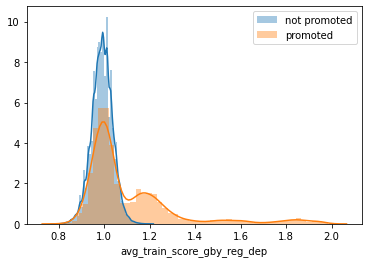

In [56]:
sns.distplot(df_new[df_new['is_promoted'] == 0]['avg_train_score_gby_reg_dep'], label = 'not promoted')
sns.distplot(df_new[df_new['is_promoted'] == 1]['avg_train_score_gby_reg_dep'], label='promoted');
plt.legend()
plt.show()

In [360]:

train, test = train_test_split(df, test_size= 0.2, random_state = 42)

In [361]:
X_train = train.drop('is_promoted', axis=1)
y_train = train['is_promoted']
X_test = test.drop('is_promoted', axis=1)
y_test = test['is_promoted']

In [362]:
print(X_train.shape, X_test.shape)

(43846, 13) (10962, 13)


In [81]:
class CalculateNewFeature():
    
    def __init__(self):
        self.df_region_depart_mean_score = pd.DataFrame()
        self.df_region_depart_KPI_avg_score = pd.DataFrame()
        self.df_region_depart_awards_won = pd.DataFrame()
    
    def fit(self, x_dataset, y=None):
        #self.df_region_depart_mean_score = x_dataset.groupby(['region', 'department'])['avg_training_score'].agg('mean').unstack()
        #self.df_region_depart_los_mean_score = x_dataset.groupby(['region', 'department'])['length_of_service'].agg('mean').unstack()
        return self

    def calculate_score_wrt_reg_and_depart(self, x):
        return x['avg_training_score']/self.df_region_depart_mean_score.loc[x['region']][x['department']]

    def calculate_df_region_depart_KPI_avg_score(self, x):
        if self.df_region_depart_KPI_avg_score.loc[x['region']][x['department']] == 0:
            return 0
        return x['KPIs_met >80%']/self.df_region_depart_KPI_avg_score.loc[x['region']][x['department']]
        
    
    def calculate_df_region_depart_awards_won(self, x):
        try:
            return x['awards_won?']/self.df_region_depart_awards_won.loc[x['region']][x['department']]
        except:
            return 0
    
    def transform(self, x_dataset, y=None):
        self.df_region_depart_mean_score = x_dataset.groupby(['region', 'department'])['avg_training_score'].agg('mean').unstack()
        self.df_region_depart_KPI_avg_score = x_dataset.groupby(['region', 'department'])['KPIs_met >80%'].agg('mean').unstack()
        self.df_region_depart_awads_won = x_dataset.groupby(['region', 'department'])['awards_won?'].agg('mean').unstack()
        x_dataset = x_dataset.assign(avg_test_score_gby_reg_dep = x_dataset.apply(self.calculate_score_wrt_reg_and_depart, axis=1))
        x_dataset = x_dataset.assign(KPIs_score_gby_reg_dep = x_dataset.apply(self.calculate_df_region_depart_KPI_avg_score, axis=1))
        x_dataset = x_dataset.assign(awards_won_gby_reg_dep = x_dataset.apply(self.calculate_df_region_depart_awards_won, axis=1))
        a = pd.DataFrame(StandardScaler().fit_transform(x_dataset[['avg_test_score_gby_reg_dep', 'KPIs_score_gby_reg_dep']]) , columns=['avg_test_score_gby_reg_dep', 'KPIs_score_gby_reg_dep'])
        a['KPI_and_training_Score'] = a['avg_test_score_gby_reg_dep']+a['KPIs_score_gby_reg_dep'] 
        x_dataset = x_dataset.join(a['KPI_and_training_Score']) 
        return x_dataset

In [82]:
class Scale():
    
    def __init__(self):
        self.minmax_scale = MinMaxScaler()
    
    def fit(self, x_dataset, y=None):
        self.minmax_scale.fit(x_dataset)
        return self

    def transform(self, x_dataset, y=None):
        return self.minmax_scale.transform(x_dataset)

In [83]:
class Impute_Missing_Data():
    
    def __init__(self, cat_var, num_var):
        self.cat_var = cat_var
        self.num_var = num_var
        self.sin = SimpleImputer(strategy='mean')
        self.sic = SimpleImputer(strategy='most_frequent')
    
    def fit(self, x_dataset, y=None):
        self.sic.fit(x_dataset[self.cat_var])
        self.sin.fit(x_dataset[self.num_var])
        return self

    def transform(self, x_dataset, y=None):
        x_dataset.loc[:][self.cat_var] = self.sic.transform(x_dataset[self.cat_var])
        x_dataset.loc[:][self.num_var] = self.sin.transform(x_dataset[self.num_var])
        x_dataset['KPI_and_training_Score'].fillna(value=0, inplace=True)
        #x_dataset['awards_won_gby_reg_dep'].fillna(value=0, inplace=True)
        return x_dataset

In [136]:
pre_process = ColumnTransformer(remainder='passthrough', 
                                transformers=[
                                              ('one_hot_encoding', ce.OneHotEncoder(), ['gender','education','recruitment_channel']),
                                              #('binary_encoding', ce.BinaryEncoder(), ['department', 'region']),
                                              ('drop_col', 'drop', [ 'gender', 
                                                                    'employee_id', 'recruitment_channel',
                                                                    'avg_training_score', 'education','department', 
                                                                    'region', 'KPIs_met >80%'])
                                             ])

In [154]:

num_var = ['previous_year_rating']
cat_var = ['education']

pip = Pipeline(steps=[('calculate_new_feature', CalculateNewFeature()),
                     ('impute_missing', Impute_Missing_Data(cat_var=cat_var, num_var=num_var)),
                     ('pre_process', pre_process),
                      ('scale', Scale()),
                     ])

In [155]:
X_train_ext= pip.fit_transform(X_train)

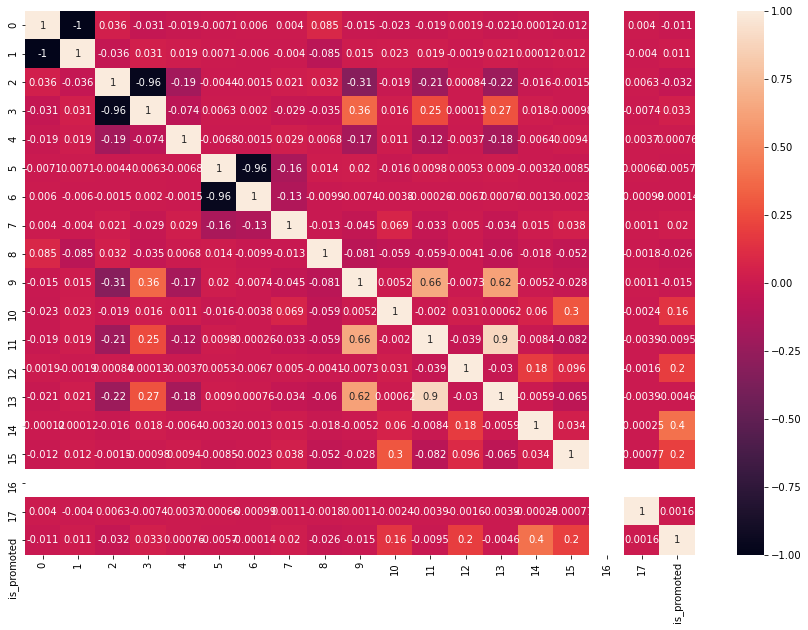

In [156]:

fig = plt.gcf()
fig.set_size_inches(15,10)
sns.heatmap(pd.concat([df_train, y_train], axis=1).corr(), annot=True)

In [157]:
df_train = pd.DataFrame(X_train_ext, index=X_train.index)

In [158]:
pca = PCA(n_components=2, random_state=42)
principalComponents = pca.fit_transform(X_train_ext)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'], index=df_train.index)

In [159]:
principal_df_target = pd.concat([principalDf, y_train], axis=1)

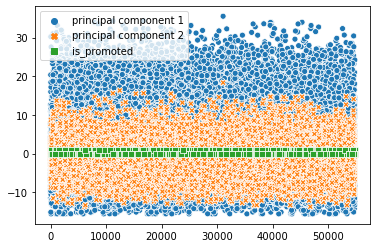

In [125]:
sns.scatterplot(data=principal_df_target, hue='is_promoted')

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principal_df_target['is_promoted'] == target
    ax.scatter(principal_df_target.loc[indicesToKeep, 'principal component 1']
               , principal_df_target.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [144]:
np.sum(principal_df_target['is_promoted'] == 1)

3760

In [145]:
principal_df_target.loc[principal_df_target['is_promoted'] == 1, 'principal component 1']

29884    21.270838
14533     1.841960
19067     7.262690
48953    -7.020168
21014    13.058530
           ...    
11016   -11.079768
8792      0.632225
10627    -9.204183
18431    -4.242769
6265    -10.153589
Name: principal component 1, Length: 3760, dtype: float64

In [163]:
X_train_ext

array([[1.        , 0.        , 1.        , ..., 0.29214929, 0.        ,
        0.21925283],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.29289479],
       [1.        , 0.        , 1.        , ..., 0.12199313, 0.        ,
        0.24166151],
       ...,
       [0.        , 1.        , 1.        , ..., 0.12445887, 0.        ,
        0.18793628],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.17773551],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.12415528]])

In [183]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)))

In [186]:
class_weights

{0: 0.5468991667913985, 1: 5.830585106382979}

In [424]:
clf = XGBClassifier(gamma = 0.5,learning_rate = 0.0480,max_depth = 10,min_child_weight = 2,n_estimators = 1000,
                    random_state=42, scale_pos_weight=4)

C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:46:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:47:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


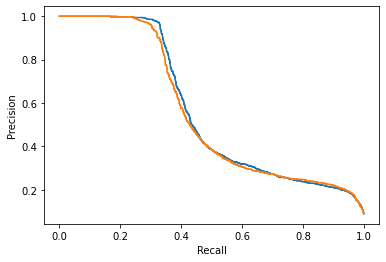

In [419]:
skf = StratifiedKFold(n_splits=2)

fold_no = 1

final_f1_score_dict = {}
final_accuracy_score_dict = {}
for train_index, test_index in skf.split(X_train, y_train):
    accuracy_dict = {}
    f1_score_dict = {}
    X_train_fold = X_train.iloc[train_index,:]
    X_test_fold = X_train.iloc[test_index,:]
    y_train_fold = y_train.iloc[train_index]
    y_test_fold = y_train.iloc[test_index]
    #print(test)
    
    X_train_ext= pip.fit_transform(X_train_fold)
    X_test_ext= pip.transform(X_test_fold)
    mod = clf.fit(X_train_ext,y_train_fold)
    pred = mod.predict_proba(X_test_ext)
    #keep prbabilities for possitive outcome only
    pre,rec,th = precision_recall_curve(y_test_fold,pred[:,1])
    plt.plot(rec,pre)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    for th in range(10, 100, 10):
        y_pred_th = (pred[:,0] <= (th/100)).astype('int')
        #print("accuracy for threshold : ", th/100, " : ", accuracy_score(y_test_fold, y_pred_th))
        #print("F1 score for threshold : " ,th/100, " : ", f1_score(y_test_fold, y_pred_th))
        #print(confusion_matrix(y_test_fold, y_pred_th))
        #print(classification_report(y_test_fold, y_pred_th))
        accuracy_dict.update({th:accuracy_score(y_test_fold, y_pred_th)})
        f1_score_dict.update({th:f1_score(y_test_fold, y_pred_th)})
    final_f1_score_dict.update({fold_no:f1_score_dict})
    final_accuracy_score_dict.update({fold_no:accuracy_dict})
    fold_no += 1

In [329]:
for key,value in final_f1_score_dict.items():
    print(value)

{10: 0.47916666666666674, 20: 0.4847298355520752, 30: 0.494876660341556, 40: 0.4906876790830946, 50: 0.4825789645066754, 60: 0.46106442577030815, 70: 0.44504995458673935, 80: 0.4113652609006433, 90: 0.3735715223959017}
{10: 0.46442845723421267, 20: 0.4755954705193283, 30: 0.48174633044787357, 40: 0.477506199078994, 50: 0.4693418940609952, 60: 0.4466811751904243, 70: 0.41626794258373206, 80: 0.39432904714803824, 90: 0.3653326786152713}


In [330]:
final_accuracy_score_dict

{1: {10: 0.9407015463212152,
  20: 0.9399717191990148,
  30: 0.9392875062719518,
  40: 0.9351366145144369,
  50: 0.9275190439264699,
  60: 0.9122382885553985,
  70: 0.8885189070838845,
  80: 0.8497468412169867,
  90: 0.7824659033891347},
 2: {10: 0.9388769785157141,
  20: 0.9387401359303015,
  30: 0.9371892532956256,
  40: 0.932719062172148,
  50: 0.9245997354376682,
  60: 0.9072207270902705,
  70: 0.877571500250878,
  80: 0.8324134470647265,
  90: 0.7641746111389864}}

In [230]:
parameters = {
    'gamma':[0.5,0.6,0.7,0.8],
    'n_estimators':[200,400,600],
    'scale_pos_weight':[5,10,15,20]
}

In [232]:
cv = GridSearchCV(XGBClassifier(learning_rate = 0.0480,max_depth = 10,min_child_weight = 2,random_state=42), 
                  parameters, cv=5, verbose=1)

In [236]:
X_train_ext = pip.fit_transform(X_train)
cv.fit(X_train_ext, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:17:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:30:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:38:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:39:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:39:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:50:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:01:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:02:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:02:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:03:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:12:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:12:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:12:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:13:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:26:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:26:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:27:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:27:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 81.4min finished


[01:31:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.048, max_delta_step=None,
                                     max_depth=10, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, valid

In [237]:
cv.best_params_

{'gamma': 0.5, 'n_estimators': 600, 'scale_pos_weight': 5}

In [239]:
cv.best_score_

0.9157277821100115

In [245]:
pred

array([[9.7228855e-01, 2.7711429e-02],
       [9.9935389e-01, 6.4613647e-04],
       [9.7792715e-01, 2.2072880e-02],
       ...,
       [8.1312895e-01, 1.8687108e-01],
       [9.6910244e-01, 3.0897541e-02],
       [9.9969435e-01, 3.0566263e-04]], dtype=float32)

In [249]:
(pred[:,0] <= (10/100)).astype('int')

array([0, 0, 0, ..., 0, 0, 0])

In [304]:
precision, recall, threshold = precision_recall_curve(y_test_fold,pred[:,1])

In [270]:
#create a data frame of dictionaries and check the average f1 score and accuracy. Start CLT


In [287]:
print(precision)

[0.08995646 0.08991291 0.08991721 ... 1.         1.         1.        ]


In [272]:
recall

array([1.00000000e+00, 9.99468085e-01, 9.99468085e-01, ...,
       1.06382979e-03, 5.31914894e-04, 0.00000000e+00])

In [273]:
threshold

array([2.4537227e-04, 2.4559954e-04, 2.4578252e-04, ..., 9.9999297e-01,
       9.9999332e-01, 9.9999499e-01], dtype=float32)

In [299]:
print(pred, (pred[:,1] <= (60/100)).astype('int'))

[[9.7228855e-01 2.7711429e-02]
 [9.9935389e-01 6.4613647e-04]
 [9.7792715e-01 2.2072880e-02]
 ...
 [8.1312895e-01 1.8687108e-01]
 [9.6910244e-01 3.0897541e-02]
 [9.9969435e-01 3.0566263e-04]] [1 1 1 ... 1 1 1]


In [310]:
precision[:-1].size

20821

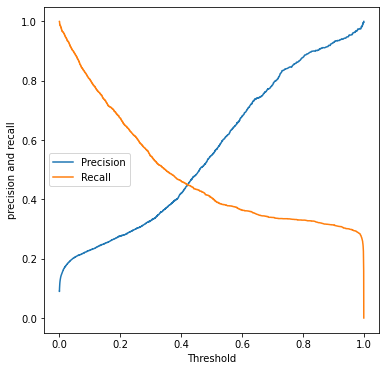

In [324]:
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(y=precision[:-1], x=threshold,label='Precision')
sns.lineplot(y=recall[:-1],x=threshold,label='Recall')
ax.set_ylabel("precision and recall")
ax.set_xlabel("Threshold")
ax.legend(loc='center left');

In [331]:

from imblearn.over_sampling import SMOTE

In [425]:

smote = SMOTE(random_state=42,sampling_strategy=0.80)

In [426]:
pip_sm =  Pipeline(steps=[('calculate_new_feature', CalculateNewFeature()),
                     ('impute_missing', Impute_Missing_Data(cat_var=cat_var, num_var=num_var)),
                     ('pre_process', pre_process),
                     ('scale', Scale())
                     ])

In [409]:
X_train_smote = pip_sm.fit_transform(X_train)

In [410]:
x_smote, y_smote = smote.fit_resample(X_train_smote, y_train)

In [427]:
mod = clf.fit(x_smote,y_smote)

C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [342]:
final_accuracy_score_dict

{1: {10: 0.8590530359726588,
  20: 0.8654393054931896,
  30: 0.8692311530210048,
  40: 0.87302300054882,
  50: 0.875717208002794,
  60: 0.8779124881504765,
  70: 0.8801576610287881,
  80: 0.8837000449034575,
  90: 0.8856458613979943},
 2: {10: 0.985780571770693,
  20: 0.9878261737264881,
  30: 0.9824377588185401,
  40: 0.9722596417701941,
  50: 0.9608342064561194,
  60: 0.9438207853115801,
  70: 0.9230654093698548,
  80: 0.8979693658633937,
  90: 0.8630444544229906},
 3: {10: 0.9866287481913885,
  20: 0.9885745646859253,
  30: 0.9826373297410568,
  40: 0.9724592126927106,
  50: 0.9586389263084368,
  60: 0.9396297959387317,
  70: 0.9184752781519733,
  80: 0.89467644564187,
  90: 0.8583046450132216},
 4: {10: 0.9832360425086065,
  20: 0.9871775682283092,
  30: 0.9826872224716858,
  40: 0.9720600708476775,
  50: 0.9573916080427082,
  60: 0.940078830514394,
  70: 0.9181260290375692,
  80: 0.8904355635383925,
  90: 0.8525669809908696}}

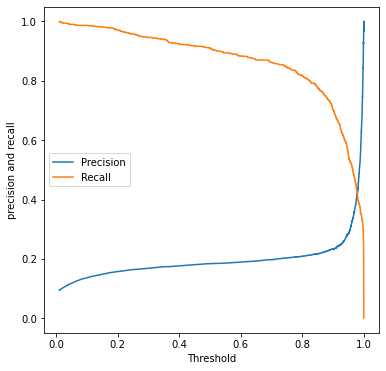

In [390]:
precision, recall, threshold = precision_recall_curve(y_test,pred_f[:,1])
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(y=precision[:-1], x=threshold,label='Precision')
sns.lineplot(y=recall[:-1],x=threshold,label='Recall')
ax.set_ylabel("precision and recall")
ax.set_xlabel("Threshold")
ax.legend(loc='center left');

In [430]:
X_test_smote = pip_sm.fit_transform(X_test)

In [431]:
pred_f = mod.predict_proba(X_test_smote)

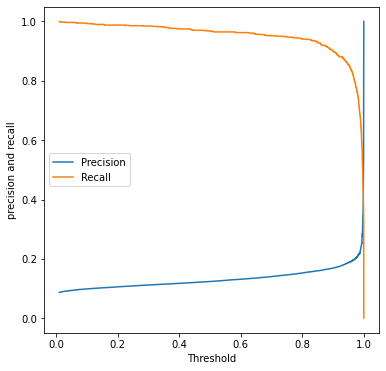

In [432]:
precision, recall, threshold = precision_recall_curve(y_test,pred_f[:,1])
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(y=precision[:-1], x=threshold,label='Precision')
sns.lineplot(y=recall[:-1],x=threshold,label='Recall')
ax.set_ylabel("precision and recall")
ax.set_xlabel("Threshold")
ax.legend(loc='center left');

In [433]:
for th in range(0, 110, 5):
    y_pred_th = (pred_f[:,0] <= (th/100)).astype('int')
    print("accuracy for threshold : ", th/100, " : ", accuracy_score(y_test, y_pred_th))
    print("F1 score for threshold : " ,th/100, " : ", f1_score(y_test, y_pred_th))
    print(confusion_matrix(y_test, y_pred_th))
    print(classification_report(y_test, y_pred_th))

accuracy for threshold :  0.0  :  0.9171683999270206
F1 score for threshold :  0.0  :  0.0
[[10054     0]
 [  908     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10054
           1       0.00      0.00      0.00       908

    accuracy                           0.92     10962
   macro avg       0.46      0.50      0.48     10962
weighted avg       0.84      0.92      0.88     10962

accuracy for threshold :  0.05  :  0.6815362160189746
F1 score for threshold :  0.05  :  0.30775332143565337
[[6695 3359]
 [ 132  776]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.79     10054
           1       0.19      0.85      0.31       908

    accuracy                           0.68     10962
   macro avg       0.58      0.76      0.55     10962
weighted avg       0.91      0.68      0.75     10962

accuracy for threshold :  0.1  :  0.6255245393176427
F1 score for threshold :  0.1  :  0

C:\Users\LPT-2517\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 0.15  :  0.27309496845170683
[[5625 4429]
 [  64  844]]
              precision    recall  f1-score   support

           0       0.99      0.56      0.71     10054
           1       0.16      0.93      0.27       908

    accuracy                           0.59     10962
   macro avg       0.57      0.74      0.49     10962
weighted avg       0.92      0.59      0.68     10962

accuracy for threshold :  0.2  :  0.5620324758255792
F1 score for threshold :  0.2  :  0.26240589952373633
[[5307 4747]
 [  54  854]]
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     10054
           1       0.15      0.94      0.26       908

    accuracy                           0.56     10962
   macro avg       0.57      0.73      0.48     10962
weighted avg       0.92      0.56      0.65     10962

accuracy for threshold :  0.25  :  0.5369458128078818
F1 score for threshold :  0.25  :  0.25309005297233667
[[5026 5028]
 [  48  860]]
              preci

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10054
           1       0.08      1.00      0.15       908

    accuracy                           0.08     10962
   macro avg       0.04      0.50      0.08     10962
weighted avg       0.01      0.08      0.01     10962



In [356]:
X_train

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,log_length_of_service
3872,43253,Sales & Marketing,region_19,Bachelor's,m,other,1,31,5.0,5,1,0,48,1.609438
11619,67983,Technology,region_13,Master's & above,m,sourcing,1,34,1.0,4,0,0,78,1.386294
36178,17959,Technology,region_22,Bachelor's,m,other,3,29,4.0,4,1,0,77,1.386294
29884,50522,Sales & Marketing,region_2,Master's & above,m,other,1,54,4.0,15,1,0,47,2.708050
22968,62721,R&D,region_7,Bachelor's,m,sourcing,1,31,5.0,6,0,0,86,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,70143,Procurement,region_22,Master's & above,f,sourcing,3,36,3.0,4,0,0,67,1.386294
54343,48082,Procurement,region_2,Bachelor's,f,sourcing,1,27,NaN,1,0,0,68,0.000000
38158,62588,Operations,region_11,Bachelor's,f,sourcing,1,34,5.0,7,1,0,65,1.945910
860,61087,Analytics,region_15,Master's & above,m,other,3,35,5.0,3,0,0,86,1.098612


In [416]:
from collections import Counter
coun = Counter(y_smote)

In [417]:
coun

Counter({0: 40086, 1: 32068})

In [401]:
40/24

1.6666666666666667

In [392]:
35/65

0.5384615384615384

In [398]:
Counter(y_train)

Counter({0: 40086, 1: 3760})